In [1]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
from thresholds import *

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")

In [2]:
exp = {}
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}
T = 100

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path = path_to_data / f"figure4-nbinom-{dynamics}.num_steps{T}"
    if (path / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})

xlabel = r"Number of time steps"
titles = {"ising": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
couplingLabels = {"ising": r"J\langle k \rangle", "sis": r"\lambda \langle k \rangle", "cowan": r"\nu\langle k \rangle"}

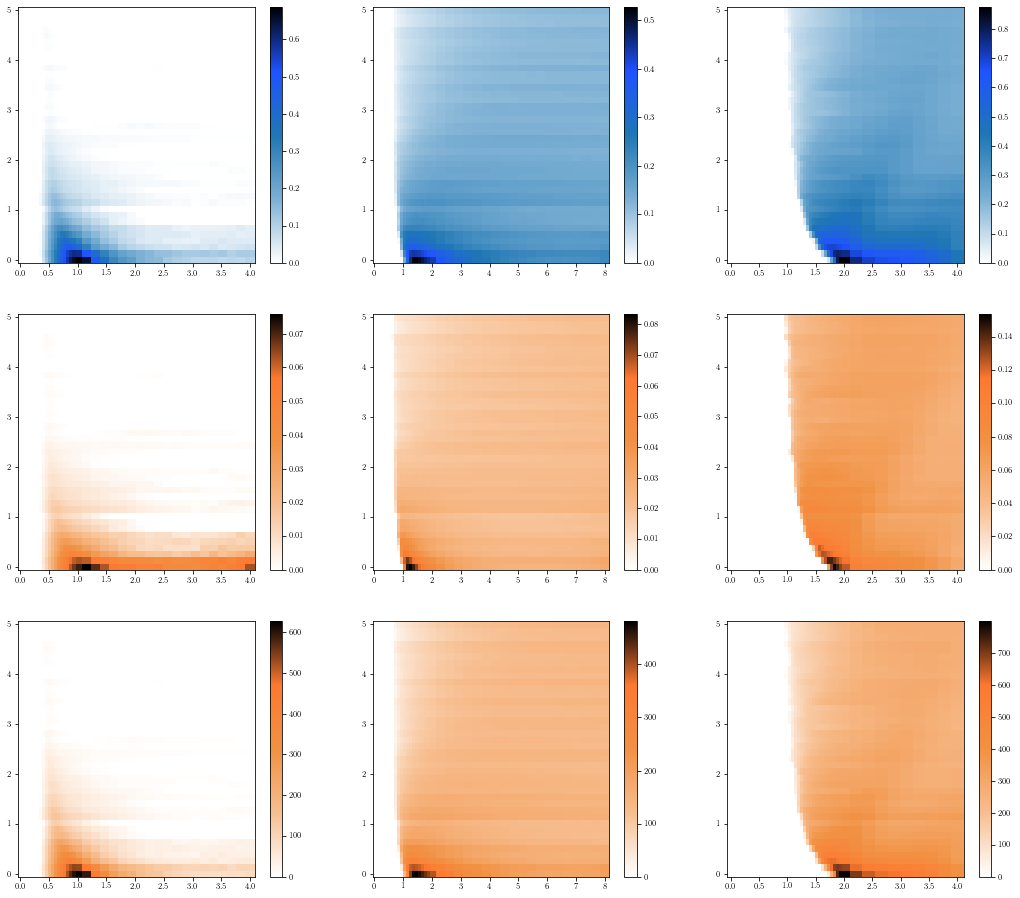

In [60]:
SCALE=2
fig, ax = plt.subplots(3, 3, figsize=(SCALE*9, SCALE*8))

recon_cmap = display.palettes["blues"].mpl_colormap
pred_cmap = display.palettes["oranges"].mpl_colormap

for i, dynamics in enumerate(all_dynamics):
    g_params = exp[dynamics].config.graph.heterogeneity
    d_params = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        d_params = [pp / exp[dynamics].config.dynamics.recovery_prob for pp in d_params]
    mi[dynamics]["mid"][mi[dynamics]["mid"] < 0] = 0
    recon = mi[dynamics] / hg[dynamics]
    GP, DP = np.meshgrid(g_params, d_params)
    p_recon = ax[0, i].pcolor(
        DP, GP,
        recon["mid"], 
        cmap=recon_cmap, 
        shading="auto",
        vmin=0,
        vmax=np.max(recon["mid"]),
    )
    fig.colorbar(p_recon, ax=ax[0,i])
    
    pred = mi[dynamics] / hx[dynamics]
    p_pred = ax[1, i].pcolor(
        DP, GP,
        pred["mid"], 
        cmap=pred_cmap, 
        shading="auto",
        vmin=0,
    )
    fig.colorbar(p_pred, ax=ax[1,i])
    
    p_pred = ax[2, i].pcolor(
        DP, GP,
        mi[dynamics]["mid"], 
        cmap=pred_cmap, 
        shading="auto",
        vmin=0,
    )
    fig.colorbar(p_pred, ax=ax[2,i])



In [58]:
print(exp["sis"].config.format())

ExperimentConfig(name=`figure4-nbinom-sis.num_steps100`): 
|	dynamics(name=`sis`): 
|	|	num_steps = 100
|	|	infection_prob = [0.0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263157894735, 0.47368421052631576, 0.5263157894736842, 0.5789473684210527, 0.631578947368421, 0.6842105263157894, 0.7368421052631579, 0.7894736842105263, 0.8421052631578947, 0.894736842105263, 0.9473684210526315, 1.0, 1.1578947368421053, 1.3157894736842106, 1.4736842105263157, 1.631578947368421, 1.7894736842105263, 1.9473684210526314, 2.1052631578947367, 2.263157894736842, 2.4210526315789473, 2.5789473684210527, 2.7368421052631575, 2.894736842105263, 3.052631578947368, 3.2105263157894735, 3.3684210526315788, 3.526315789473684, 3.6842105263157894, 3.8421052631578947, 4.0]
|	|	recovery_prob = 0.5
|	|	auto_infection_prob = 0.0001
|	|	normalize = True
|	end
|	graph(name=`nbinom_cm`): 
|	|	size = 100
|	|	edge_coun